In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist

import gymnasium as gym


In [2]:
from algorithms.reinforce import ReinforceAgent
from networks.policy import DiscretePolicy, ContinuousPolicy
from utils.eval_utils import *

# REINFORCE

Evaluate ReinforceAgent on Classic Control Environments

### Acrobot

In [3]:
ENV_NAME = 'Acrobot-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)

agent = ReinforceAgent(policy, policy_lr=.5, optimiser=optim.SGD)

agent.train(env, num_iters=50, batch_size=10)

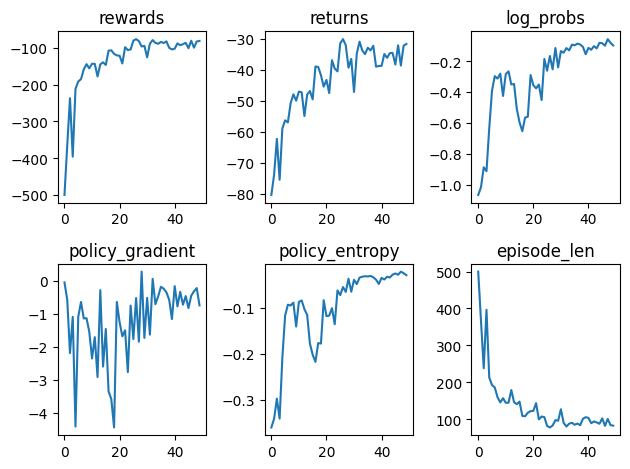

In [4]:
plot_training_results(agent.batch_results)

### CartPole

In [5]:
ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    2*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

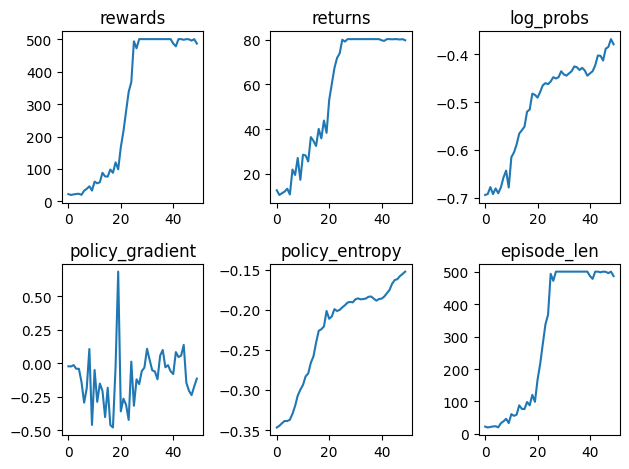

In [6]:
plot_training_results(agent.batch_results)

In [32]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: 444.0, 1: 156.0, 2: 356.0, 3: 256.0, 4: 364.0, 5: 500.0, 6: 423.0, 7: 500.0, 8: 363.0, 9: 423.0}


### Mountain Car

In [7]:
ENV_NAME = 'MountainCar-v0'
env = gym.make(ENV_NAME)

policy = DiscretePolicy(
    env.observation_space.shape[0], 
    env.action_space.n, 
    1*(env.action_space.n+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

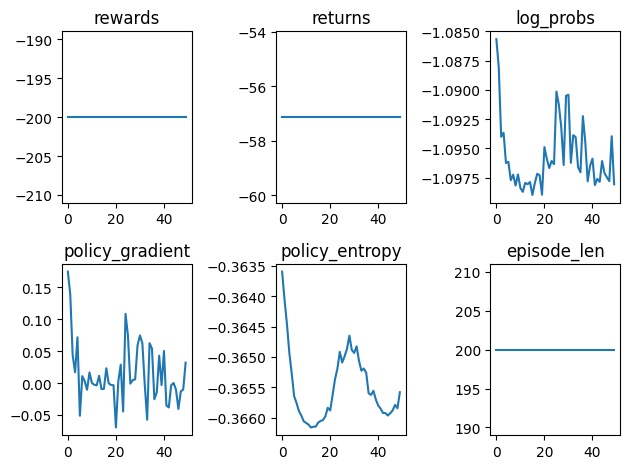

In [8]:
plot_training_results(agent.batch_results)

In [35]:
rewards = eval_agent(agent, env, 10)
print(rewards)

{0: -200.0, 1: -200.0, 2: -200.0, 3: -200.0, 4: -200.0, 5: -200.0, 6: -200.0, 7: -200.0, 8: -200.0, 9: -200.0}


### Mountain Car Continuous

In [9]:
ENV_NAME = 'MountainCarContinuous-v0'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)
agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)

agent.train(env, num_iters=50, batch_size=10)

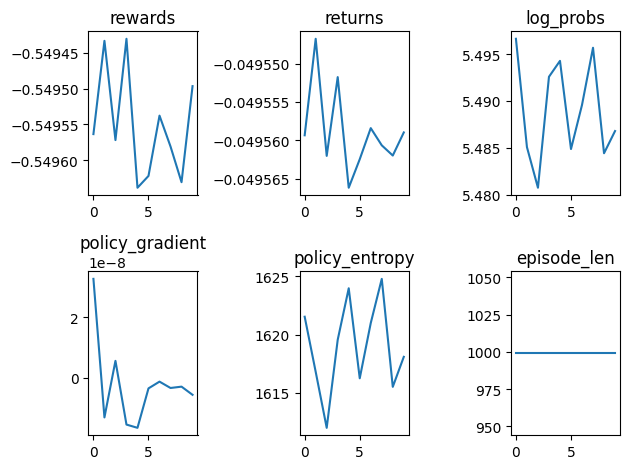

In [14]:
plot_training_results(agent.batch_results)

### Pendulum

In [18]:
ENV_NAME = 'Pendulum-v1'
env = gym.make(ENV_NAME)

policy = ContinuousPolicy(
    env.observation_space.shape[0], 
    env.action_space.shape[0], 
    2*(env.action_space.shape[0]+env.observation_space.shape[0])
)

agent = ReinforceAgent(policy, policy_lr=.03, optimiser=optim.Adam)
agent.train(env, num_iters=20, batch_size=10)

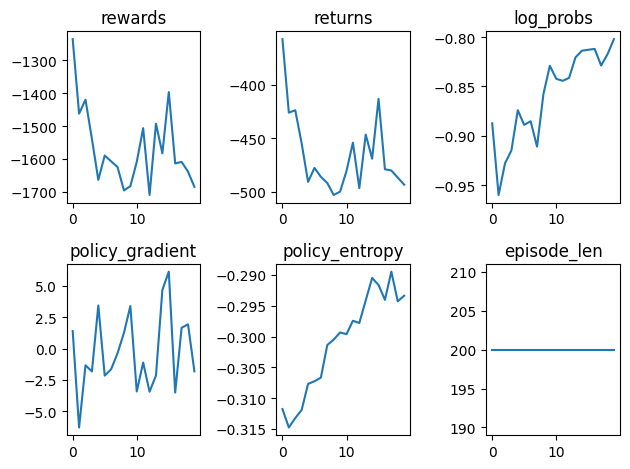

In [19]:
plot_training_results(agent.batch_results)

In [121]:
from torch.utils.data import Dataset
import numpy.random

class Transition:

    def __init__(self, action, state, reward, next_state, done):
        self.action = action
        self.state = state
        self.reward = reward
        self.done = done
        self.next_state = next_state
    
    def __repr__(self):
        return f"""
        action: {self.action},
        \nstate: {self.state},
        \nreward: {self.reward},
        \ndone: {int(self.done)},
        \nnext_state: {self.next_state}
        """

class ReplayBuffer():

    def __init__(
        self, 
        max_size: int, 
        weight_func: callable = lambda x: [1/len(x)]*len(x),
        with_replacement: bool = False
    ):
        self.max_size = max_size
        self.transitions = []
        self.weight_func = weight_func
        self.with_replacement = with_replacement
        
    def insert(self, transition: Transition):
        ## requires insertion of single transition
        if len(self.transitions) + 1 < self.max_size:
            self.transitions.append(transition)
        else:
            self.transitions = self.transitions[1:]
            self.transitions.append(transition)
    
    def calculate_weights(self):
        return self.weight_func(self.transitions)

    def sample_transitions(self, num_samples: int):
        transition_weights = self.calculate_weights()
        return np.random.choice(
                self.transitions,
                p=transition_weights,
                size = num_samples,
                replace = self.with_replacement
            ).tolist()
        
    def sample(self, num_samples: int):

        (
            actions,
            states,
            rewards,
            dones,
            next_states
        ) = zip(
                *[(i.action, i.state, i.reward, i.done, i.next_state) 
                for i in self.sample_transitions(num_samples)]
        )

        ## convert to pytorch
        return (
            torch.tensor(actions),
            torch.tensor(np.array(states)),
            torch.tensor(rewards),
            torch.tensor(dones, dtype=torch.int32),
            torch.tensor(np.array(next_states))
        )

        




In [122]:
buffer = ReplayBuffer(
    max_size = 3
)

env = gym.make('CartPole-v1')
state, info = env.reset()
done = False
i = 0
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    t= Transition(
        action=action, 
        state=state, 
        reward=i, 
        done=done, 
        next_state=next_state
    )

    buffer.insert(t)
    # print(i, buffer.transitions)
    # print("=====================")
    if i == 15:
        print(f"stopping at {i}")
        done = True
    i += 1
    

stopping at 15


In [123]:
actions, states, rewards, dones, next_states = zip(*[(i.action, i.state, i.reward, i.done, i.next_state) for i in buffer.sample(2)])
torch.tensor(actions)

AttributeError: 'Tensor' object has no attribute 'action'

In [124]:
buffer.sample(2)

(tensor([0, 0]),
 tensor([[-0.0275,  0.0348, -0.0387, -0.0154],
         [-0.0275,  0.0348, -0.0387, -0.0154]]),
 tensor([15, 14]),
 tensor([0, 0], dtype=torch.int32),
 tensor([[ 0.0331, -0.3306, -0.1735,  0.0234],
         [ 0.0359, -0.1383, -0.1693, -0.2115]]))

In [ ]:
transitions = [
    Transition(
        np.array
    )
]

In [74]:
import numpy as np
f = lambda x: [1/len(x)]*len(x)
np.random.choice(a, p=f(a),size= 5, replace = True)

array([4, 3, 3, 4, 2])

In [57]:
a = [1,1,1,4,4,4,2,2,2,3,3,3]
sorted(range(len(a)), key=lambda k: a[k])

[0, 1, 2, 6, 7, 8, 9, 10, 11, 3, 4, 5]

In [58]:
a[1:]

[1, 1, 4, 4, 4, 2, 2, 2, 3, 3, 3]

In [53]:
from torch.utils.data import RandomSampler
T=torch.tensor(
    [
        [1,1,1],
        [2,2,2],
        [3,3,3],
        [4,4,4],
        [5,5,5]
    ]
)
buf = ReplayBuffer(losses=T)

samp = RandomSampler(
    data_source=buf,
    replacement=True,
    num_samples=5
    )

T[list(samp)]

tensor([[3, 3, 3],
        [4, 4, 4],
        [4, 4, 4],
        [2, 2, 2],
        [3, 3, 3]])

In [54]:
int(T.size(0)*.7)

3

In [31]:
batch_results = agent.batch_results
j={key: [batch[key] for batch in batch_results.values()] for key in next(iter(batch_results.values()))}



# [batch_resfor k, v in batch_results[i].items() for i in batch_results.keys()]

In [30]:
batch_results.values()

dict_values([{'log_probs': array(-0.88740623, dtype=float32), 'rewards': np.float64(-1235.5776595176776), 'returns': array(-357.33157053), 'policy_gradient': array(1.39659599), 'policy_entropy': array(-0.3117633, dtype=float32), 'episode_len': 200.0}, {'log_probs': array(-0.96010613, dtype=float32), 'rewards': np.float64(-1462.2440129583945), 'returns': array(-426.1790804), 'policy_gradient': array(-6.30367149), 'policy_entropy': array(-0.31475592, dtype=float32), 'episode_len': 200.0}, {'log_probs': array(-0.9280458, dtype=float32), 'rewards': np.float64(-1419.9127833639673), 'returns': array(-423.91487439), 'policy_gradient': array(-1.3403967), 'policy_entropy': array(-0.3132241, dtype=float32), 'episode_len': 200.0}, {'log_probs': array(-0.91498405, dtype=float32), 'rewards': np.float64(-1538.7959491774484), 'returns': array(-454.95447112), 'policy_gradient': array(-1.82688008), 'policy_entropy': array(-0.3119187, dtype=float32), 'episode_len': 200.0}, {'log_probs': array(-0.8741935

In [28]:
for i in next(iter(batch_results.values())):
    print(i)

log_probs
rewards
returns
policy_gradient
policy_entropy
episode_len
